In [1]:
%matplotlib inline

import degraph as dg
from degraph.cairo_plot import StatusPlotter
import tensorflow as tf
import networkx as nx
from IPython.display import display, Image
from matplotlib import pyplot as plt
from PIL import Image

import tempfile
import os
from datetime import datetime
import traceback

### Config variables

In [2]:
plt.rcParams['figure.figsize'] = [12., 8.]
RASTER_SHAPE = (200, ) * 2      # Shape of the raster image where the RBF are plotted
output_path = tempfile.mkdtemp()

print(f'Output path: {output_path}')
print(f'To start Tensorboard execute:\ntensorboard --logdir {output_path}')

Output path: /var/folders/qb/s_cf7xpj2zz0dw871jw45_fh0000gp/T/tmpgaammtd0
To start Tensorboard execute:
tensorboard --logdir /var/folders/qb/s_cf7xpj2zz0dw871jw45_fh0000gp/T/tmpgaammtd0


### Graph definition
A graph is defined in terms of adjacency matrix.

In [3]:
graph = dg.GraphRepr(adjacency=nx.to_numpy_matrix(nx.balanced_tree(3, 3)),
                     dim=len(RASTER_SHAPE))

### Model definition

In [4]:
@tf.function
def path_length_loss(edges: tf.Tensor):
    """
    Create loss component that penalizes the length of the edges.
    :param edges:
    :return:
    """
    loss_factor = 1.
    edges *= tf.convert_to_tensor(RASTER_SHAPE, dtype=dg.TF_FLOAT)
    lengths = dg.math.path_length(edges)
    lengths = tf.reduce_mean(lengths) * loss_factor
    return lengths

def create_summary_writer_factory(output_path: str):
    """
    Create summary writer for Tensorboard.
    :return:
    """
    path = os.path.join(output_path, f"logs")
    print(f"logs path: {path}")

    def fun():
        return tf.summary.create_file_writer(path)
    return fun

model = dg.Model()
with model.as_active():
    # Create entity representing edges
    edges = dg.piecewise_linear_edges(graph, steps=25, space_radius=10., name='ed', trainable=True)
    # Create entity representing vertexes
    vx = dg.vertexes(graph, trainable=True, name='vx')

    # Create a raster where Wendland RBF is used to represent the vertexes interaction.
    raster = dg.aggregate_rasters([
        dg.rbf_net_raster(vx, shape=RASTER_SHAPE, rbf='wendland', spread=3.0, peak=1.0)
    ], bias=-1.)
    dg.summary_histogram(raster, scope='raster_histo')

    # Loss contributions
    losses = {
        'metrics.raster_loss': dg.sse_loss(raster),
        'metrics.bounds_loss': dg.unit_sphere_bounds_loss(edges),
        'metrics.path_length_loss': dg.lambda_(path_length_loss, edges)
    }
    for loss_ in losses.items():
        dg.summary_scalar(loss_[1], scope=loss_[0])     # Loss contribution summary (Tensorboard)
    loss = dg.reduce_sum(losses.values(), name='loss')  # Aggregate the individual losses
    dg.summary_scalar(loss, scope='metrics.loss')       # Summarise the overall loss on Tensorboard

### Model fit

In [5]:
fit_session = datetime.now().strftime('%Y%m%d%H%m%S')
print(f'Current fit session: {fit_session}')
session_path = os.path.join(output_path, fit_session)
print(f'Session path: {session_path}')

model.summary_writer_factory = create_summary_writer_factory(session_path)
plotter = StatusPlotter(graph=graph, path_prefix=os.path.join(session_path, 'step'))

try:
    plotter(index='init')  # Plot initial state

    # Create optimizer (SGD)
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-1, decay=2., momentum=0.9, clipnorm=1.0)
    # Run the fitting
    history = model.fit(steps=1000,
                        loss=loss,
                        optimizer=optimizer,
                        # Snapshot callback, plot the status every X seconds)
                        callbacks=dg.callback.SnapshotCallback(plotter, interval=5))
except AssertionError:
    traceback.print_exc()

plotter(index='end')    # Plot final state

Current fit session: 20200207210247
Session path: /var/folders/qb/s_cf7xpj2zz0dw871jw45_fh0000gp/T/tmpgaammtd0/20200207210247
logs path: /var/folders/qb/s_cf7xpj2zz0dw871jw45_fh0000gp/T/tmpgaammtd0/20200207210247/logs


fit: 100%|██████████| 1000/1000 [01:19<00:00, 12.53it/s, step=999, loss=4.87]


In [6]:
history.head(5).style.set_caption('History table head')

,step,datetime,metrics.raster_loss,metrics.bounds_loss,metrics.path_length_loss,metrics.loss,loss
0,0,2020-02-07 21:31:49.628702,1.89189e-05,0,305.541,305.541,305.541
1,1,2020-02-07 21:31:52.571967,0,0,235.66,235.66,235.66
2,2,2020-02-07 21:31:52.621943,0,83.4864,381.655,465.141,465.141
3,3,2020-02-07 21:31:52.666550,0.242819,32.4358,391.202,423.881,423.881
4,4,2020-02-07 21:31:52.717894,0,7.0186,322.419,329.438,329.438


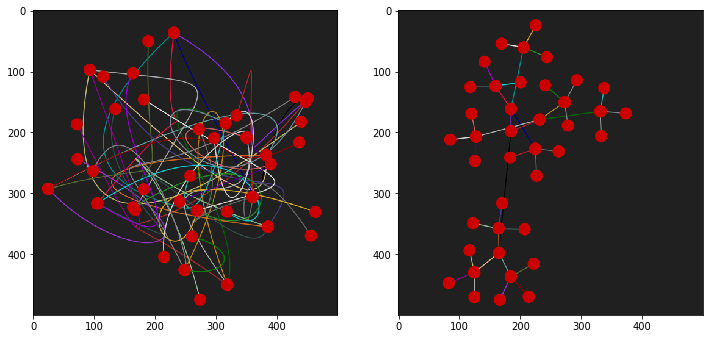

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(Image.open(os.path.join(session_path, 'step_plot_init.png')))
ax = fig.add_subplot(1, 2, 2)
ax.imshow(Image.open(os.path.join(session_path, 'step_plot_end.png')))